# **Telco Customer Churn Prediction**
## **Overview**
Customer churn refers to the loss of customers who no longer use a company's product or service within a time period. This problem is measured as a percentage of lost customers relative to the total customers. Sustained high churn rates will suffocate the company's revenue and impact long-term viability. Hence, this metric needs to be monitored closely and rectified if any spikes or upward trend occur.

This project aims to **predict whether a customer will churn** based on their demographic info, subscribed services, and account details.

---

## **Dataset Description**
This project uses the [**Telco Customer Churn**](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download) dataset, originally provided as part of the **IBM Sample Data Sets**.

Each row in the dataset represents a single customer, while each column describes the customer attribute.

### Data Contents
The dataset contains the following categories of information:

#### 1. Customer Churn
- **Churn**: Indicates whether the customer left the company within the last month (`Yes` / `No`).

#### 2. Subscribed Services
Information about the services each customer has signed up for, including:
- Phone service and multiple lines
- Internet service (DSL, fiber optic, or none)
- Online security and backup
- Device protection and technical support
- Streaming TV and streaming movies

#### 3. Account Information
Details related to the customer’s account and billing:
- Tenure (length of time as a customer)
- Contract type
- Payment method
- Paperless billing status
- Monthly charges
- Total charges

#### 4. Demographic Information
Basic customer characteristics:
- Gender
- Senior citizen status
- Partner and dependent information

---

## **Project Goal**
The goal of this project is to:
- Build a **neural network model** to predict customer churn
- Compare its performance against a simple baseline model

## **Setups**

In [1]:
# Create and activate venv, run in terminal:
# python -m venv .venv
# .venv\Scripts\Activate
# pip install -r requirements.txt
# Note that im using torch with gpu (cuda 13.0) the package is quite big, you can use torch cpu instead but remove the to(device) from the code

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
import optuna

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
print(torch.cuda.device_count())

1


In [5]:
torch.__version__

'2.9.1+cu130'

In [6]:
torch.version.cuda

'13.0'

In [7]:
df = pd.read_csv("TelcoChurnData.csv")

## **Checks and Fixes**

In [8]:
df.info()
# no null values found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
# Check for customer duplications
df.value_counts('customerID').map(lambda x: x>1).any()

np.False_

In [11]:
# Check unique values, especially for text data
for column in df.columns:
    unique_values = np.sort(df[column].unique())
    print(f"{column}: {unique_values}")

customerID: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['No' 'Yes']
Dependents: ['No' 'Yes']
tenure: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'No phone service' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'No internet service' 'Yes']
OnlineBackup: ['No' 'No internet service' 'Yes']
DeviceProtection: ['No' 'No internet service' 'Yes']
TechSupport: ['No' 'No internet service' 'Yes']
StreamingTV: ['No' 'No internet service' 'Yes']
StreamingMovies: ['No' 'No internet service' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['No' 'Yes']
PaymentMethod: ['Bank transfer (automatic)' 'Credit card (automatic)' 'Elect

#### Column type fix

In [12]:
# Total charges should be a numeric column
# Check for non numeric values
invalid_mask = pd.to_numeric(df['TotalCharges'], errors='coerce').isna()
'"' + df.loc[invalid_mask, 'TotalCharges'] + '"'

488     " "
753     " "
936     " "
1082    " "
1340    " "
3331    " "
3826    " "
4380    " "
5218    " "
6670    " "
6754    " "
Name: TotalCharges, dtype: object

In [13]:
# Change whitespace only values above to be nan
df['TotalCharges'] = df['TotalCharges'].replace(r'^\s+$', np.nan, regex=True)
df.loc[invalid_mask, 'TotalCharges']

488     NaN
753     NaN
936     NaN
1082    NaN
1340    NaN
3331    NaN
3826    NaN
4380    NaN
5218    NaN
6670    NaN
6754    NaN
Name: TotalCharges, dtype: object

In [14]:
# Change col type to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [15]:
# Find a way to fill the nan values
# Perhaps we can get total charges from monthly charges multiplied by tenure
test_df = df.loc[~invalid_mask, ['tenure','MonthlyCharges','TotalCharges']]
test_df['MaybeTotalCharges'] = test_df['tenure'] * test_df['MonthlyCharges']
test_df['Diff'] = abs((test_df['MaybeTotalCharges'] - test_df['TotalCharges']) / test_df['TotalCharges'])
test_df.sort_values(by='Diff', ascending=False)
# Unfortunately there's a difference between the calculation and the real value

,tenure,MonthlyCharges,TotalCharges,MaybeTotalCharges,Diff
2950,4,20.20,55.70,80.80,0.450628
4203,7,20.05,96.80,140.35,0.449897
900,2,19.50,27.55,39.00,0.415608
4262,2,66.40,94.55,132.80,0.404548
5595,2,19.40,61.05,38.80,0.364455
...,...,...,...,...,...
5736,1,20.05,20.05,20.05,0.000000
6933,1,69.60,69.60,69.60,0.000000
6943,1,30.50,30.50,30.50,0.000000
1491,1,19.55,19.55,19.55,0.000000


In [16]:
# Check the difference distribution, if small then it's a pretty good approximation
pd.cut(test_df['Diff'],bins=[x/100 for x in range(0,101,10)]).value_counts()

Diff
(0.0, 0.1]    6032
(0.1, 0.2]     317
(0.2, 0.3]      53
(0.3, 0.4]      12
(0.4, 0.5]       4
(0.5, 0.6]       0
(0.6, 0.7]       0
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]       0
Name: count, dtype: int64

In [17]:
# The distribution seems ok, check the calculation for the nan values
df.loc[invalid_mask, 'TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'])

488     0.0
753     0.0
936     0.0
1082    0.0
1340    0.0
3331    0.0
3826    0.0
4380    0.0
5218    0.0
6670    0.0
6754    0.0
Name: TotalCharges, dtype: float64

In [18]:
# Oddly all are zeros, check the tenure and monthly charges
df.loc[invalid_mask, ['tenure','MonthlyCharges']]

,tenure,MonthlyCharges
488,0,52.55
753,0,20.25
936,0,80.85
1082,0,25.75
1340,0,56.05
3331,0,19.85
3826,0,25.35
4380,0,20.00
5218,0,19.70
6670,0,73.35


In [19]:
# Check for similar cases of tenure 0, is there one where the TotalCharges is not null
df.loc[df['tenure']==0,['tenure','MonthlyCharges','TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN
3331,0,19.85,NaN
3826,0,25.35,NaN
4380,0,20.00,NaN
5218,0,19.70,NaN
6670,0,73.35,NaN


In [20]:
# Since the are no similar cases, a decision must be made
# Though it is preferable to get more context of the data if possible

# For now, since we know that the tenure is in months, then 0 must mean the customer churned before the first billing
# This means the TotalCharges must be either the MonthlyCharge if there is no free cancelation policy
# Or TotalCharges must be 0 if there is a free cancelation policy

# A free cancelation policy is uncommon for a telco subscription, so we'll set it to the MonthlyCharge
df.loc[invalid_mask, 'TotalCharges'] = df.loc[invalid_mask, 'MonthlyCharges']
df.loc[invalid_mask, ['TotalCharges','MonthlyCharges']]

,TotalCharges,MonthlyCharges
488,52.55,52.55
753,20.25,20.25
936,80.85,80.85
1082,25.75,25.75
1340,56.05,56.05
3331,19.85,19.85
3826,25.35,25.35
4380,20.00,20.00
5218,19.70,19.70
6670,73.35,73.35


#### Back to checks

In [21]:
# Sanity check
df[df['MonthlyCharges'] > df['TotalCharges']]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [22]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [23]:
# drop customer id
df.drop(columns=['customerID'], inplace=True)

## **EDA**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


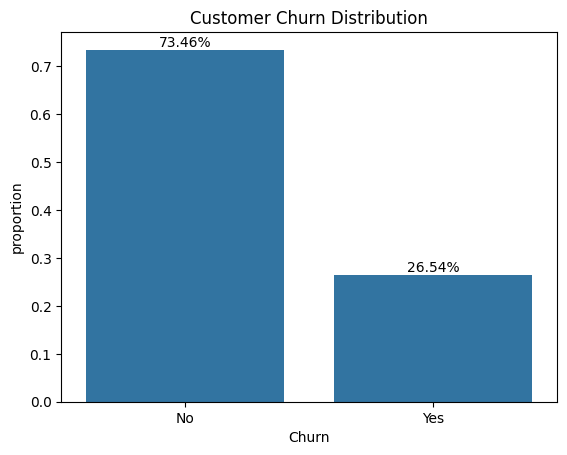

In [25]:
ax = sns.countplot(x='Churn', data=df, stat="proportion")
labels = (df['Churn'].value_counts() / df['Churn'].count() * 100).map(lambda x: f'{x:.2f}%')
ax.bar_label(ax.containers[0], labels = labels) 
plt.title("Customer Churn Distribution")
plt.show()

In [26]:
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_subplots = [len(numeric_columns), 1] # Adjustable to preference
# SeniorCitizen is binary, we can change the zero/ones to no/yes but its not necessary
category_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling','PaymentMethod']
category_subplots = [4, int(np.ceil(len(category_columns)/4))]

[]

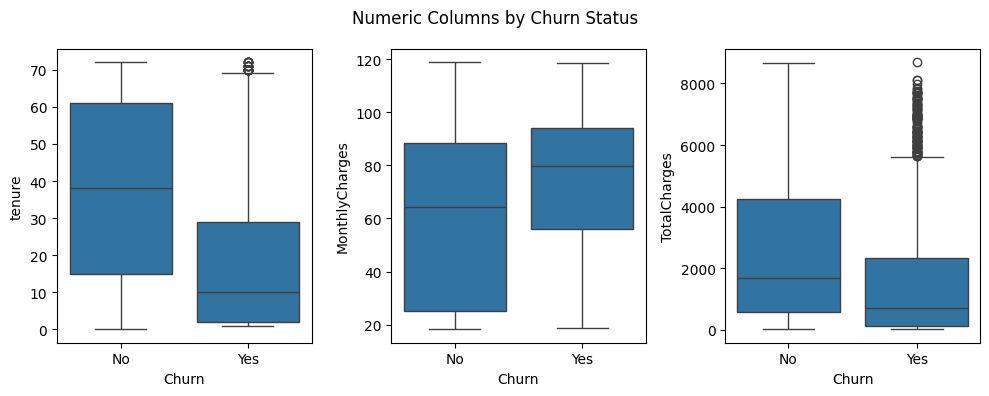

In [27]:
fig, axes = plt.subplots(*reversed(numeric_subplots), figsize=(10,4))

for i in range(len(numeric_columns)):
    ax = axes.flatten()[i]
    column = numeric_columns[i]
    sns.boxplot(x='Churn', y=column, data=df, ax=ax)

fig.suptitle("Numeric Columns by Churn Status")
plt.tight_layout()
plt.plot()

[]

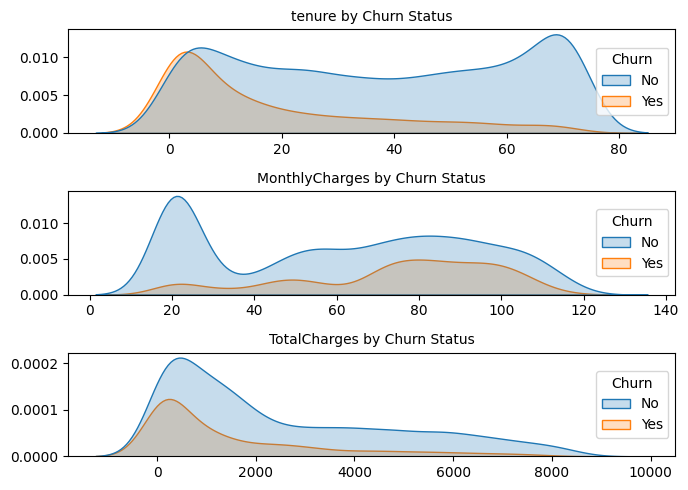

In [28]:
fig, axes = plt.subplots(*numeric_subplots, figsize=(7,5))

for i in range(len(numeric_columns)):
    ax = axes.flatten()[i]
    column = numeric_columns[i]
    sns.kdeplot(x=column, hue='Churn', fill=True, data=df, ax=ax)
    sns.move_legend(ax, 'center right')
    ax.set_title(f'{column} by Churn Status', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.plot()

[]

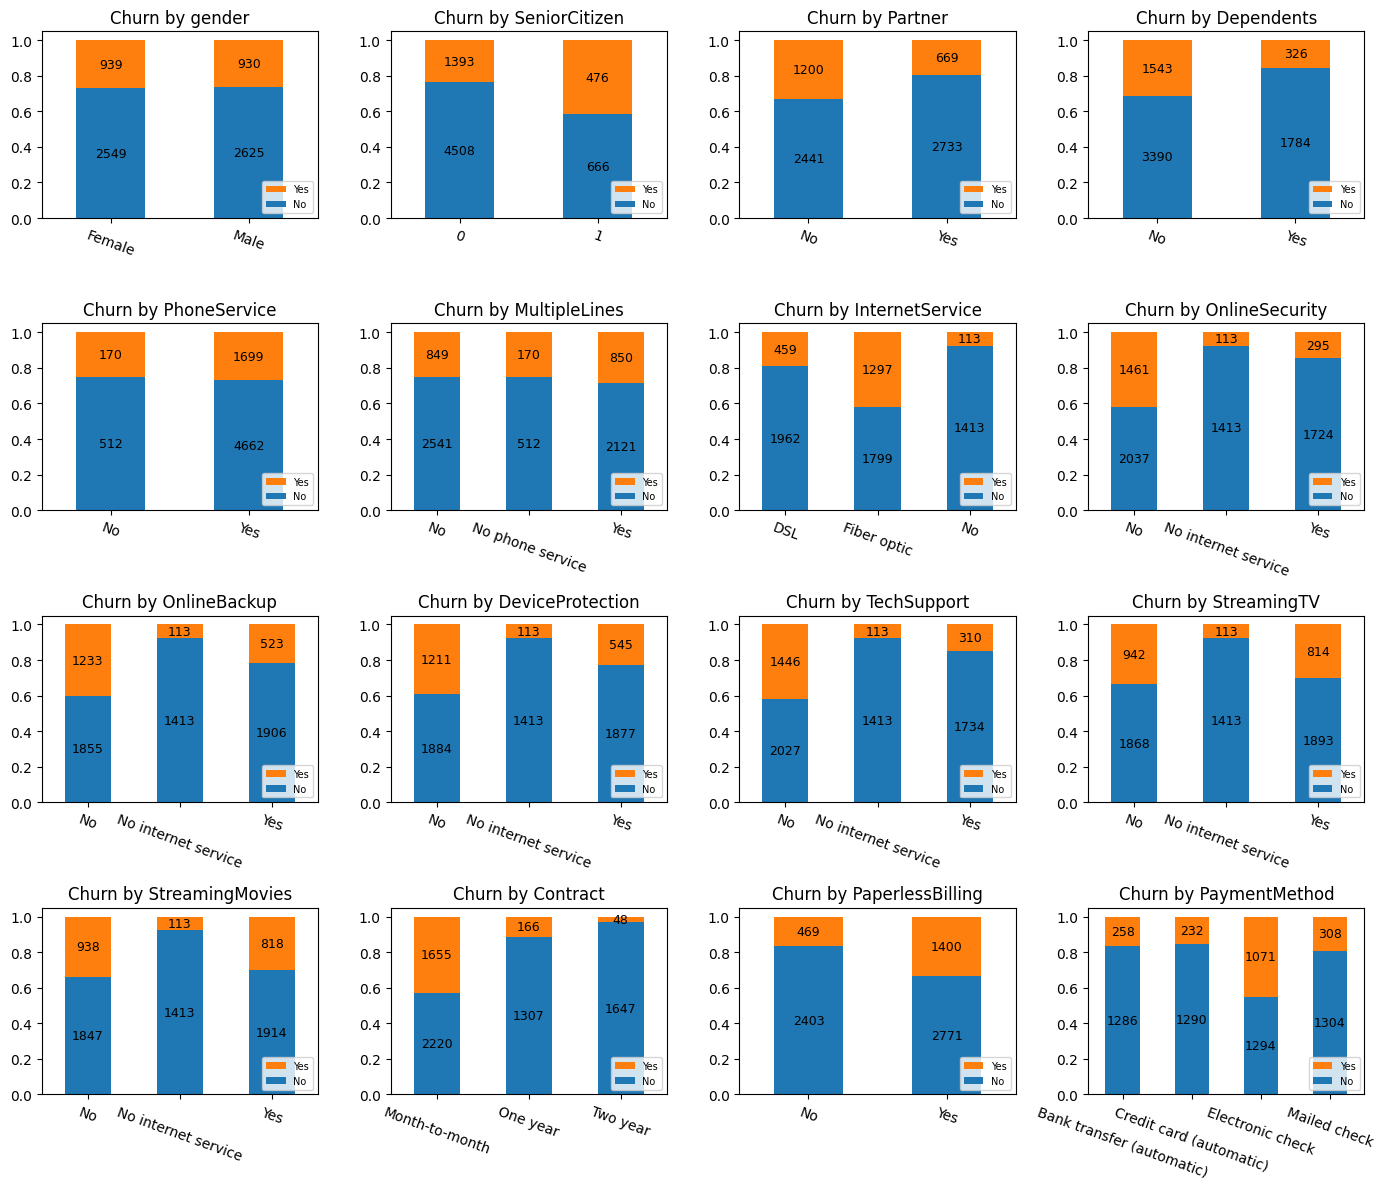

In [29]:
fig, axes = plt.subplots(*reversed(category_subplots), figsize=(14,12))

for i in range(len(category_columns)):
    ax = axes.flatten()[i]
    column = category_columns[i]
    crosstab_norm = pd.crosstab(df[column],df['Churn'], normalize='index')
    crosstab_norm.plot(kind='bar', stacked=True, ax=ax)
    crosstab_count =  pd.crosstab(df[column],df['Churn'])
    # Add count to each bar
    for idx, cat in enumerate(crosstab_count.index):
        cumulative = 0
        for churn_val in crosstab_count.columns:
            count = crosstab_count.loc[cat, churn_val]
            if count == 0:
                continue

            proportion = crosstab_norm.loc[cat, churn_val]
            ax.text(
                idx,
                cumulative + proportion / 2,
                f'{count}',
                ha='center',
                va='center',
                fontsize=9
            )
            cumulative += proportion
    ax.set_title(f'Churn by {column}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-20)
    ax.legend(loc='lower right', reverse=True, fontsize=7)

plt.tight_layout()
plt.plot()

## **Modelling**

In [30]:
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

In [31]:
# Encode x vars
X = pd.get_dummies(X, drop_first=True)

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## Logistic Regression (Baseline)

In [33]:
auc_scores = []

for train_idx, val_idx in skf.split(X, y):
    # Train validation split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    preds = model.predict_proba(X_val_scaled)[:, 1]
    auc = roc_auc_score(y_val, preds)
    auc_scores.append(auc)

print(f"Logistic Regression CV ROC-AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

Logistic Regression CV ROC-AUC: 0.8454 ± 0.0139


## Neural Network

In [34]:
# Basic NN
nn_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # Train validation split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Convert to tensor
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val.values, dtype=torch.float32)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Train
    for epoch in range(20):
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb).squeeze(), yb)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_val_t.to(device)).squeeze().cpu().numpy()

    auc = roc_auc_score(y_val, preds)
    nn_auc_scores.append(auc)

print(f"NN CV ROC-AUC: {np.mean(nn_auc_scores):.4f} ± {np.std(nn_auc_scores):.4f}")


NN CV ROC-AUC: 0.8438 ± 0.0143


In [35]:
# NN with class weights, to emphasize the churners
nn_wcw_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

    # class weight
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train
    )
    pos_weight = torch.tensor(weights[1], dtype=torch.float32).to(device)

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
        # remove sigmoid, use sigmoid after training, because bcelost doesn't accept class weights but bce with logits does
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    for epoch in range(20):
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb).squeeze(), yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = torch.sigmoid(model(X_val_t.to(device)).squeeze()).cpu().numpy()

    auc = roc_auc_score(y_val, preds)
    nn_wcw_auc_scores.append(auc)

print(f"NN WCW CV ROC-AUC: {np.mean(nn_wcw_auc_scores):.4f} ± {np.std(nn_wcw_auc_scores):.4f}")


NN WCW CV ROC-AUC: 0.8419 ± 0.0131


In [36]:
# Next: tune nn
def nn_objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    hidden1 = trial.suggest_int("hidden1", 32, 128)
    hidden2 = trial.suggest_int("hidden2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
        X_val_t = torch.tensor(X_val, dtype=torch.float32)

        train_ds = TensorDataset(X_train_t, y_train_t)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array([0, 1]),
            y=y_train
        )
        pos_weight = torch.tensor(weights[1], dtype=torch.float32).to(device)

        model = nn.Sequential(
            nn.Linear(X_train.shape[1], hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        ).to(device)

        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # early stopping vars
        best_auc = 0
        patience = 3
        patience_counter = 0

        for epoch in range(30):
            model.train()
            for xb, yb in train_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb).squeeze(), yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                preds = torch.sigmoid(model(X_val_t.to(device)).squeeze()).cpu().numpy()
                auc = roc_auc_score(y_val, preds)

            if auc > best_auc:
                best_auc = auc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

        auc_scores.append(best_auc)

    return np.mean(auc_scores)


In [37]:
nn_study = optuna.create_study(direction="maximize")
nn_study.optimize(nn_objective, n_trials=50)

[I 2026-01-03 16:15:51,503] A new study created in memory with name: no-name-d8377b9f-0d7b-4b7b-a911-9136e133d97a
[I 2026-01-03 16:16:08,881] Trial 0 finished with value: 0.8434020290435486 and parameters: {'lr': 0.0002382680504881817, 'hidden1': 85, 'hidden2': 40, 'dropout': 0.09754518425076264, 'weight_decay': 3.0418875970271405e-06, 'batch_size': 64}. Best is trial 0 with value: 0.8434020290435486.
[I 2026-01-03 16:16:14,839] Trial 1 finished with value: 0.8444607733350266 and parameters: {'lr': 0.004728828073701283, 'hidden1': 81, 'hidden2': 50, 'dropout': 0.05128171665853785, 'weight_decay': 0.00023182457233165155, 'batch_size': 64}. Best is trial 1 with value: 0.8444607733350266.
[I 2026-01-03 16:16:26,535] Trial 2 finished with value: 0.8436639937956347 and parameters: {'lr': 0.004321979912024396, 'hidden1': 44, 'hidden2': 64, 'dropout': 0.2639822379872987, 'weight_decay': 5.720096010203237e-06, 'batch_size': 32}. Best is trial 1 with value: 0.8444607733350266.
[I 2026-01-03 16:

In [38]:
print(nn_study.best_value)
print(nn_study.best_params)

0.84592964452403
{'lr': 0.0008210642134812427, 'hidden1': 97, 'hidden2': 29, 'dropout': 0.15607599368648156, 'weight_decay': 9.416341433347007e-05, 'batch_size': 32}


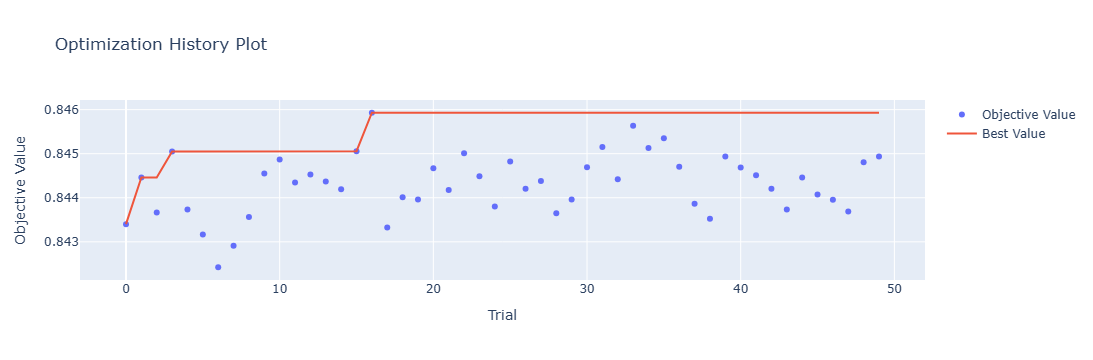

In [39]:
optuna.visualization.plot_param_importances(nn_study)
optuna.visualization.plot_optimization_history(nn_study)

## XGBoost

In [40]:
# XGBoost 
xgb_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    d_train = xgb.DMatrix(
        X_train.values,
        label=y_train.values
    )
    d_val = xgb.DMatrix(
        X_val.values,
        label=y_val.values
    )

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 4,
        'eta': 0.05, # learning rate
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 0, # random state
    }

    model = xgb.train(
        params,
        d_train,
        num_boost_round=300,
        evals=[(d_val, "val")],
        verbose_eval=False
    )

    preds = model.predict(d_val)
    auc = roc_auc_score(y_val, preds)
    xgb_auc_scores.append(auc)

print(f"XGB AUC: {np.mean(xgb_auc_scores):.4f} ± {np.std(xgb_auc_scores):.4f}")

XGB AUC: 0.8439 ± 0.0112


In [41]:
# XGBoost with class weights
xgb_wcw_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    d_train = xgb.DMatrix(
        X_train.values,
        label=y_train.values
    )
    d_val = xgb.DMatrix(
        X_val.values,
        label=y_val.values
    )

    # class weights
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 4,
        'eta': 0.05, # learning rate
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight':scale_pos_weight,
        'seed': 0, # random state
    }

    model = xgb.train(
        params,
        d_train,
        num_boost_round=300,
        evals=[(d_val, "val")],
        verbose_eval=False
    )

    preds = model.predict(d_val)
    auc = roc_auc_score(y_val, preds)
    xgb_wcw_auc_scores.append(auc)

print(f"XGB WCW AUC: {np.mean(xgb_wcw_auc_scores):.4f} ± {np.std(xgb_wcw_auc_scores):.4f}")

XGB WCW AUC: 0.8441 ± 0.0113


In [42]:
# XGBoost with class weights and hyperparameter tuning
def xgb_objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda',
        'seed': 0, # random state 
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'eta': trial.suggest_float('eta', 0.01, 0.1, log=True), # learning rate
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 0.5), # minimum loss reduction to make a split
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 0.5, 5.0), # regularization lambda, making weights (leaf weights) nudges smaller
    }

    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X,y),1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        d_train = xgb.DMatrix(
            X_train.values,
            label=y_train.values
        )
        d_val = xgb.DMatrix(
            X_val.values,
            label=y_val.values
        )
    
        # class weights
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        params["scale_pos_weight"] = scale_pos_weight
        
        model = xgb.train(
            params,
            d_train,
            num_boost_round=1000,
            evals=[(d_val, "val")],
            early_stopping_rounds=50,
            verbose_eval=False
        )
    
        preds = model.predict(d_val, iteration_range=(0, model.best_iteration + 1)) # we only use trees that are good (determined by early stopping), plus one because range is exclusive at the end
        auc_scores.append(roc_auc_score(y_val, preds))
    return np.mean(auc_scores)


In [43]:
xgb_study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=50)
)

xgb_study.optimize(xgb_objective, n_trials=100)


[I 2026-01-03 16:29:08,370] A new study created in memory with name: no-name-23f2bf96-0740-444f-a89a-eed7a72bc866
[I 2026-01-03 16:29:15,281] Trial 0 finished with value: 0.8499629931007048 and parameters: {'max_depth': 3, 'eta': 0.024475527472922053, 'min_child_weight': 6, 'gamma': 0.44689546773948463, 'subsample': 0.6058256559830929, 'colsample_bytree': 0.8915442176195183, 'lambda': 0.7736919706927924}. Best is trial 0 with value: 0.8499629931007048.
[I 2026-01-03 16:29:22,335] Trial 1 finished with value: 0.8496136651646948 and parameters: {'max_depth': 4, 'eta': 0.023376466305069028, 'min_child_weight': 7, 'gamma': 0.19083956544186487, 'subsample': 0.7307717547899129, 'colsample_bytree': 0.917930983702786, 'lambda': 2.9599084272691614}. Best is trial 0 with value: 0.8499629931007048.
[I 2026-01-03 16:29:27,181] Trial 2 finished with value: 0.849008677200404 and parameters: {'max_depth': 5, 'eta': 0.03319533318098167, 'min_child_weight': 2, 'gamma': 0.03675601945388102, 'subsample':

In [44]:
print(xgb_study.best_value)
print(xgb_study.best_params)


0.8512354077591887
{'max_depth': 2, 'eta': 0.053260021784376, 'min_child_weight': 12, 'gamma': 0.33194111719948977, 'subsample': 0.6193529315570542, 'colsample_bytree': 0.893604224916943, 'lambda': 2.961922225205262}


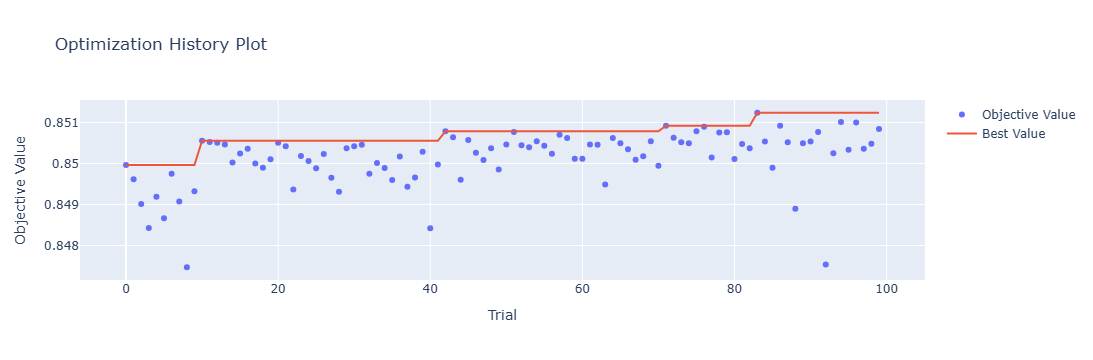

In [45]:
optuna.visualization.plot_param_importances(xgb_study)
optuna.visualization.plot_optimization_history(xgb_study)


In [46]:
# next: do feature engineering based on eda